In [2]:
import torch
print(torch.cuda.is_available())

False


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install torch torchvision opencv-python

In [4]:
import os
from PIL import Image
import torch
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

In [5]:
class FaceDataset(Dataset):
  def __init__(self,img_dir,label_dir,img_size=448,transform=None):
    self.img_dir = img_dir
    self.label_dir = label_dir
    self.img_size=img_size
    self.transform = transform
    self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

  def __len__(self):
    return len(self.img_files)

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir,self.img_files[idx])
    img = Image.open(img_path).convert("RGB")
    img = img.resize((self.img_size,self.img_size))

    label_path = os.path.join(self.label_dir,self.img_files[idx].replace('.jpg', '.txt'))
    boxes = []

    if os.path.exists(label_path):
      with open(label_path,'r') as file:
        for line in file:
          _, x_center, y_center, width, height = map(float, line.strip().split())
          boxes.append([x_center, y_center, width, height,1.0])

    boxes = torch.tensor(boxes, dtype=torch.float32)

    if self.transform:
      img = self.transform(img)

    return img, boxes

In [6]:
img_dir_train='/content/drive/My Drive/YoloData/images/train'
label_dir_train='/content/drive/My Drive/YoloData/labels/train'
img_dir_test='/content/drive/My Drive/YoloData/images/val'
label_dir_test='/content/drive/My Drive/YoloData/labels/val'

data_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_val_dataset = FaceDataset(
    img_dir=img_dir_train,
    label_dir=label_dir_train,
    transform=data_transforms
)

test_dataset = FaceDataset(
    img_dir=img_dir_test,
    label_dir=label_dir_test,
    transform=data_transforms
)

train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

In [7]:
first_image, first_boxes = train_dataset[0]

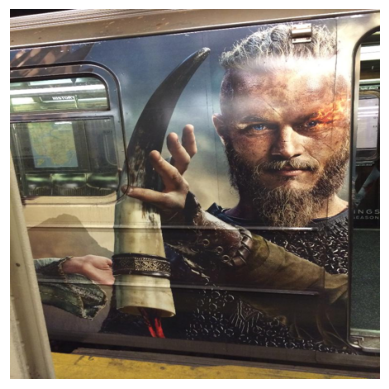

In [8]:
import matplotlib.pyplot as plt

# Prikaz slike
plt.imshow(first_image.permute(1, 2, 0))  # Premesti dimenzije iz (C, H, W) u (H, W, C)
plt.axis('off')  # Isključi prikaz osa
plt.show()


In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [10]:
import torch
import torch.nn as nn
import numpy as np

In [11]:
class YOLO(nn.Module):
  def __init__(self,grid_size=7,num_bboxes=2):
    super(YOLO,self).__init__()
    self.grid_size=grid_size
    self.num_bboxes=num_bboxes

    self.conv_layers=nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.1)
    )

    self.fc_layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024 * self.grid_size*self.grid_size, 4096),
        nn.LeakyReLU(0.1),
        nn.Dropout(0.5),
        nn.Linear(4096, self.grid_size * self.grid_size * (self.num_bboxes * 5))
    )

    def forward(self, x):

        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = x.view(-1, self.grid_size, self.grid_size, self.num_bboxes * 5)

        bboxes = x.view(-1, self.grid_size, self.grid_size, self.num_bboxes, 5)

        bboxes[..., :4] = torch.sigmoid(bboxes[..., :4])  # x_center, y_center, width, height
        bboxes[..., 4] = torch.sigmoid(bboxes[..., 4]) #confidence

        return bboxes


In [12]:
def xywh_to_xyxy(box):
    x_center, y_center, width, height = box
    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)
    x_max = x_center + (width / 2)
    y_max = y_center + (height / 2)
    return [x_min, y_min, x_max, y_max]

In [13]:
def iou(box1, box2):
    box1 = xywh_to_xyxy(box1)
    box2 = torch.stack([xywh_to_xyxy(b) for b in box2])

    x1 = torch.max(box1[0], box2[:, 0])
    y1 = torch.max(box1[1], box2[:, 1])
    x2 = torch.min(box1[2], box2[:, 2])
    y2 = torch.min(box1[3], box2[:, 3])

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    union = box1_area + box2_area - intersection

    iou = intersection / union
    return iou

In [14]:
def non_max_suppression(boxes, scores, iou_threshold):

    if boxes.numel() == 0:
        return []

    _, indices = scores.sort(descending=True)

    keep_boxes = []

    while indices.numel() > 0:

        current = indices[0]
        keep_boxes.append(current.item())

        if indices.numel() == 1:
            break

        iou_values = iou(boxes[current], boxes[indices[1:]])

        indices = indices[1:][iou_values < iou_threshold]

    return keep_boxes


In [15]:
import torch.optim as optim

In [16]:
def yolo_loss(predictions, target, lambda_coord=5, lambda_noobj=0.5):
    coord_loss = lambda_coord * torch.sum((predictions[..., :2] - target[..., :2]) ** 2)
    coord_loss += lambda_coord * torch.sum((predictions[..., 2:4] - target[..., 2:4]) ** 2)

    obj_mask = target[..., 4] > 0
    noobj_mask = target[..., 4] == 0

    obj_loss = torch.sum((predictions[obj_mask][..., 4] - target[obj_mask][..., 4]) ** 2)

    noobj_loss = lambda_noobj * torch.sum((predictions[noobj_mask][..., 4]) ** 2)

    loss = coord_loss + obj_loss + noobj_loss
    return loss


In [17]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, targets in train_loader:
            optimizer.zero_grad()  # Resetovanje gradijenata

            # Forward pass kroz model
            predictions = model(images)

            # Izračunavanje gubitka (loss)
            loss = yolo_loss(predictions, targets)

            # Backward pass i ažuriranje težina
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}")

        # Validacija modela na validacionom skupu (opciono)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_images, val_targets in val_loader:
                val_predictions = model(val_images)
                val_loss += yolo_loss(val_predictions, val_targets).item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Validation Loss: {avg_val_loss}")
        model.train()

    print("Training complete!")

def evaluate_model(model, test_loader, iou_threshold=0.5, confidence_threshold=0.5):
    model.eval()
    all_boxes = []
    all_scores = []

    with torch.no_grad():
        for images, _ in test_loader:
            predictions = model(images)

            for i in range(predictions.shape[0]):  # Iterate over batch
                batch_boxes = []
                batch_scores = []
                for y in range(predictions.shape[1]):  # Grid cell y
                    for x in range(predictions.shape[2]):  # Grid cell x
                        for b in range(predictions.shape[3]):  # Bounding boxes per cell
                            box = predictions[i, y, x, b, :4]
                            confidence = predictions[i, y, x, b, 4]

                            if confidence > confidence_threshold:
                                batch_boxes.append(box)
                                batch_scores.append(confidence)

                batch_boxes = torch.stack(batch_boxes)
                batch_scores = torch.tensor(batch_scores)

                # Apply NMS
                kept_indices = non_max_suppression(batch_boxes, batch_scores, iou_threshold)
                final_boxes = batch_boxes[kept_indices]
                final_scores = batch_scores[kept_indices]

                all_boxes.append(final_boxes)
                all_scores.append(final_scores)

    return all_boxes, all_scores

In [19]:
#model = YOLO()
#train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)

In [28]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def draw_bounding_box(image_path, boxes, save_path=None):

    image = Image.open(image_path).convert("RGB")
    image = image.resize((448, 448))
    draw = ImageDraw.Draw(image)

    for box in boxes:
        draw.rectangle(xywh_to_xyxy(box), outline="red", width=3)

    if save_path:
        image.save(save_path)
    else:
        plt.imshow(image)
        plt.axis('off')
        plt.show()

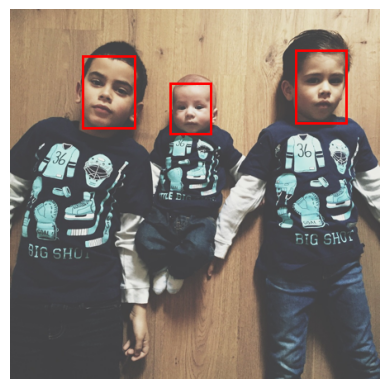

In [32]:
draw_bounding_box(image_path,boxes)